# HW06 — Деревья решений и ансамбли (dataset-04)

Цель: сравнить baseline-модели и модели недели 6 (дерево/лес/бустинг) в честном ML-эксперименте:
- фиксированный train/test split (воспроизводимость),
- подбор гиперпараметров только на train через CV,
- test используется один раз для финальной оценки,
- метрики: accuracy + f1 + ROC-AUC, для дисбаланса дополнительно PR/Average Precision,
- сохранение артефактов (метрики, параметры, модель, графики).


In [1]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from joblib import dump

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    ConfusionMatrixDisplay,
    RocCurveDisplay, PrecisionRecallDisplay,
    average_precision_score
)

from sklearn.inspection import permutation_importance

RANDOM_STATE = 42
TEST_SIZE = 0.25

DATA_PATH = Path("S06-hw-dataset-04.csv")

ART_DIR = Path("artifacts")
FIG_DIR = ART_DIR / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

print("Artifacts dir:", ART_DIR.resolve())
print("Figures dir:", FIG_DIR.resolve())
print("Data path:", DATA_PATH)


Artifacts dir: D:\AIE_1\homeworks\HW06\artifacts
Figures dir: D:\AIE_1\homeworks\HW06\artifacts\figures
Data path: S06-hw-dataset-04.csv


In [2]:
df = pd.read_csv(DATA_PATH)
display(df.head())
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())


,id,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f52,f53,f54,f55,f56,f57,f58,f59,f60,target
0,1,-1.250210,1.423474,-0.225004,-4.023138,-0.832729,-0.550874,1.772090,2.761690,-0.698750,...,10.938269,0.501178,1.600001,0.314212,1.209735,1.355697,-5.338924,1.153944,-0.153934,0
1,2,0.074328,0.376429,0.212831,-0.502074,2.017405,0.625496,1.943785,1.242030,-0.524090,...,7.775262,-4.550195,6.272586,-0.932162,-0.228543,1.735220,-3.827828,0.292165,0.273720,0
2,3,0.638481,0.060968,0.746760,2.479653,-0.292858,-0.078139,-2.918423,-0.013186,1.009135,...,-4.448447,-9.593179,-3.093519,0.029321,0.605511,0.829103,-0.085985,2.891408,0.766221,0
3,4,1.712916,-1.350969,-0.256473,1.622074,-0.445141,0.911932,-3.440345,1.505192,-1.104348,...,-1.619072,-3.237479,-5.474038,-1.582475,0.198137,3.823409,0.880395,1.148610,0.136732,0
4,5,0.905676,-0.206545,-0.068806,4.086026,-1.010045,-0.772644,-4.207688,2.506104,1.589143,...,-2.396844,-10.540129,-5.532811,-1.231203,0.000119,4.298572,-1.558235,0.924673,0.111668,0


Shape: (25000, 62)
Columns: ['id', 'f01', 'f02', 'f03', 'f04', 'f05', 'f06', 'f07', 'f08', 'f09', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'target']


### Первичный анализ данных (минимум)

In [3]:
print("Info:")
df.info()

print("\nDescribe (numeric):")
display(df.describe().T)

print("\nMissing values (top-15):")
display(df.isna().sum().sort_values(ascending=False).head(15))

print("\nTarget distribution (counts):")
display(df["target"].value_counts())

print("\nTarget distribution (share, %):")
display((df["target"].value_counts(normalize=True) * 100).round(3))



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 62 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      25000 non-null  int64  
 1   f01     25000 non-null  float64
 2   f02     25000 non-null  float64
 3   f03     25000 non-null  float64
 4   f04     25000 non-null  float64
 5   f05     25000 non-null  float64
 6   f06     25000 non-null  float64
 7   f07     25000 non-null  float64
 8   f08     25000 non-null  float64
 9   f09     25000 non-null  float64
 10  f10     25000 non-null  float64
 11  f11     25000 non-null  float64
 12  f12     25000 non-null  float64
 13  f13     25000 non-null  float64
 14  f14     25000 non-null  float64
 15  f15     25000 non-null  float64
 16  f16     25000 non-null  float64
 17  f17     25000 non-null  float64
 18  f18     25000 non-null  float64
 19  f19     25000 non-null  float64
 20  f20     25000 non-null  float64
 21  f21     25000 non-null  float

,count,mean,std,min,25%,50%,75%,max
id,25000.0,12500.500000,7217.022701,1.000000,6250.750000,12500.500000,18750.250000,25000.000000
f01,25000.0,-0.000386,1.001623,-4.370993,-0.680165,0.001859,0.679702,4.208888
f02,25000.0,-0.004872,0.995606,-4.087073,-0.675100,-0.000247,0.659523,3.984564
f03,25000.0,0.003202,1.004367,-4.103875,-0.675426,0.013272,0.683437,3.793442
f04,25000.0,0.335329,3.207537,-13.249937,-1.750048,0.403483,2.486453,15.288250
...,...,...,...,...,...,...,...,...
f57,25000.0,0.893365,2.445185,-9.508509,-0.735473,0.888535,2.516790,11.880651
f58,25000.0,-0.909479,1.962618,-7.919287,-2.226959,-0.923354,0.395648,6.778980
f59,25000.0,0.000570,0.994320,-4.038312,-0.666367,0.004381,0.666474,3.834922
f60,25000.0,-0.000754,0.997167,-3.812255,-0.665861,0.002420,0.665918,4.012639



Missing values (top-15):


id     0
f01    0
f02    0
f03    0
f04    0
f05    0
f06    0
f07    0
f08    0
f09    0
f10    0
f11    0
f12    0
f13    0
f14    0
dtype: int64


Target distribution (counts):


target
0    23770
1     1230
Name: count, dtype: int64


Target distribution (share, %):


target
0    95.08
1     4.92
Name: proportion, dtype: float64

### Формируем Х и y

In [4]:
# Формируем признаки и целевой признак
drop_cols = ["target"]
if "id" in df.columns:
    drop_cols.append("id")

X = df.drop(columns=drop_cols)
y = df["target"]

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Excluded columns:", drop_cols)


X shape: (25000, 60)
y shape: (25000,)
Excluded columns: ['target', 'id']


### Train/Test split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

print("\nTrain target distribution (share):")
display(y_train.value_counts(normalize=True))

print("\nTest target distribution (share):")
display(y_test.value_counts(normalize=True))


Train shape: (18750, 60)
Test shape: (6250, 60)

Train target distribution (share):


target
0    0.950773
1    0.049227
Name: proportion, dtype: float64


Test target distribution (share):


target
0    0.95088
1    0.04912
Name: proportion, dtype: float64

### Почему важны фиксированный seed и стратификация

- **Фиксированный `random_state` (seed)** нужен для воспроизводимости: при повторном запуске мы получим тот же train/test split и сравнение моделей будет честным.
- **`stratify=y`** сохраняет доли классов в train и test. Это особенно важно при сильном дисбалансе (dataset-04), иначе тестовая выборка может случайно оказаться “слишком лёгкой” или “слишком тяжёлой”, и метрики будут некорректно сравниваться.


## 2.3.3 Baseline’ы

Делаем два baseline’а:
- `DummyClassifier` как наивная точка отсчёта;
- `LogisticRegression` как простой линейный бейзлайн (через `Pipeline(StandardScaler + LogisticRegression)`).

In [6]:
def get_proba_or_score(model, X):
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    if hasattr(model, "decision_function"):
        return model.decision_function(X)
    return None

def evaluate_binary(model, X_data, y_true):
    y_pred = model.predict(X_data)

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    y_score = get_proba_or_score(model, X_data)
    roc_auc = None
    ap = None
    if y_score is not None:
        roc_auc = roc_auc_score(y_true, y_score)
        ap = average_precision_score(y_true, y_score)

    return {
        "accuracy": float(acc),
        "f1": float(f1),
        "roc_auc": (None if roc_auc is None else float(roc_auc)),
        "average_precision": (None if ap is None else float(ap)),
    }



In [8]:
dummy = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)

logreg = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        max_iter=3000,
        class_weight="balanced",   # полезно при сильном дисбалансе dataset-04
        random_state=RANDOM_STATE
    ))
])

baseline_models = {
    "DummyClassifier": dummy,
    "LogisticRegression": logreg
}

# общий словарь обученных моделей (будет нужен дальше для выбора лучшей модели)
models_fitted = {}

# общий словарь метрик на test (сюда потом добавим дерево/лес/бустинг)
metrics_test = {}

for name, model in baseline_models.items():
    model.fit(X_train, y_train)
    models_fitted[name] = model
    metrics_test[name] = evaluate_binary(model, X_test, y_test)

pd.DataFrame(metrics_test).T


,accuracy,f1,roc_auc,average_precision
DummyClassifier,0.95088,0.000000,0.500000,0.049120
LogisticRegression,0.77920,0.257266,0.841861,0.457002


### Короткая интерпретация baseline’ов

- `DummyClassifier`: высокая `accuracy≈0.95` из-за предсказания только большинства, поэтому `f1=0` и `roc_auc=0.5` (как случайно) — на дисбалансе accuracy обманчива.
- `LogisticRegression`: `roc_auc≈0.84` и `average_precision≈0.46` заметно лучше, модель реально различает классы и начинает находить редкий класс (`f1≈0.26`), хотя accuracy ниже.


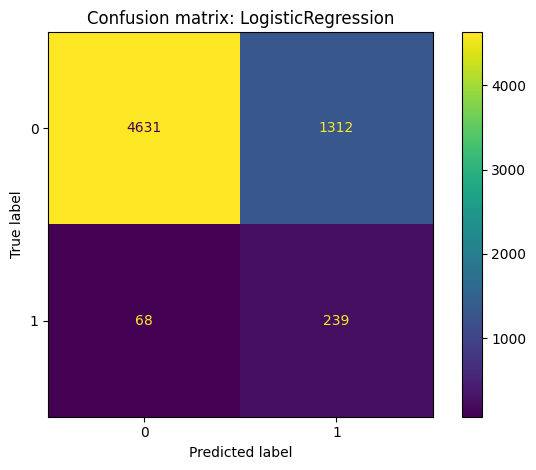

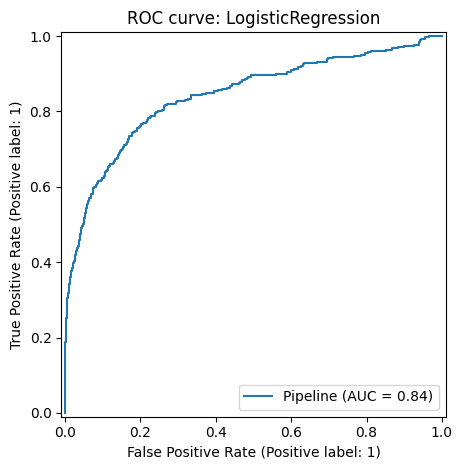

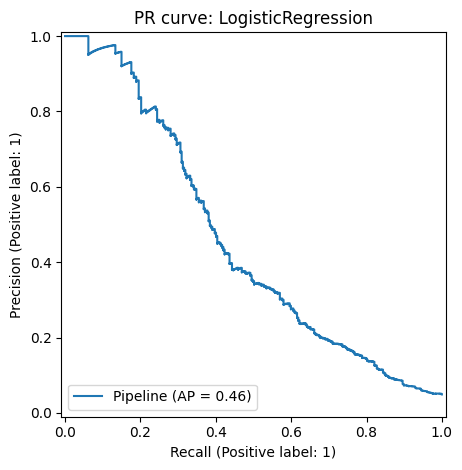

In [9]:
m = models_fitted["LogisticRegression"]

ConfusionMatrixDisplay.from_estimator(m, X_test, y_test)
plt.title("Confusion matrix: LogisticRegression")
plt.tight_layout()
plt.savefig(FIG_DIR / "cm_LogisticRegression.png", dpi=150)
plt.show()

RocCurveDisplay.from_estimator(m, X_test, y_test)
plt.title("ROC curve: LogisticRegression")
plt.tight_layout()
plt.savefig(FIG_DIR / "roc_LogisticRegression.png", dpi=150)
plt.show()

PrecisionRecallDisplay.from_estimator(m, X_test, y_test)
plt.title("PR curve: LogisticRegression")
plt.tight_layout()
plt.savefig(FIG_DIR / "pr_LogisticRegression.png", dpi=150)
plt.show()


In [10]:
with open(ART_DIR / "metrics_test.json", "w", encoding="utf-8") as f:
    json.dump(metrics_test, f, ensure_ascii=False, indent=2)

print("Saved:", ART_DIR / "metrics_test.json")


Saved: artifacts\metrics_test.json


## 2.3.4 Модели недели 6: Tee, Random Forest, boosting

In [11]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
scoring = "roc_auc"

print("CV:", cv)
print("Scoring:", scoring)

CV: StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
Scoring: roc_auc


### DecisionTreeClassifier (контроль сложности)

In [13]:
dt = DecisionTreeClassifier(
    random_state=RANDOM_STATE,
    class_weight="balanced"
)

dt_grid = {
    "max_depth": [3, 5, None],
    "min_samples_leaf": [1, 10, 50],
}

dt_search = GridSearchCV(
    estimator=dt,
    param_grid=dt_grid,
    scoring=scoring,
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=1
)

dt_search.fit(X_train, y_train)
best_dt = dt_search.best_estimator_

print("DecisionTree best params:", dt_search.best_params_)
print("DecisionTree best CV score:", float(dt_search.best_score_))

Fitting 3 folds for each of 9 candidates, totalling 27 fits
DecisionTree best params: {'max_depth': 5, 'min_samples_leaf': 50}
DecisionTree best CV score: 0.8258319108294035


### RandomForestClassifier

In [12]:
rf = RandomForestClassifier(
    n_estimators=150,                 # уменьшили ради скорости
    random_state=RANDOM_STATE,
    n_jobs=-1,
    class_weight="balanced_subsample"
)

rf_grid = {
    "max_depth": [None, 10],          # 2 варианта
    "min_samples_leaf": [1, 10],      # 2 варианта
    "max_features": ["sqrt"],         # фиксируем (ускоряет)
}  # итого 4 комбинации

rf_search = GridSearchCV(
    estimator=rf,
    param_grid=rf_grid,
    scoring=scoring,
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=1
)

rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_

print("RandomForest best params:", rf_search.best_params_)
print("RandomForest best CV score:", float(rf_search.best_score_))

Fitting 3 folds for each of 4 candidates, totalling 12 fits
RandomForest best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1}
RandomForest best CV score: 0.8918526685456573


### Boosting

In [14]:
hgb = HistGradientBoostingClassifier(random_state=RANDOM_STATE)

hgb_grid = {
    "learning_rate": [0.05, 0.1],
    "max_depth": [3, None],
    "max_iter": [200, 400],
}  # 8 комбинаций

hgb_search = GridSearchCV(
    estimator=hgb,
    param_grid=hgb_grid,
    scoring=scoring,
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=1
)

hgb_search.fit(X_train, y_train)
best_hgb = hgb_search.best_estimator_

print("HGB best params:", hgb_search.best_params_)
print("HGB best CV score:", float(hgb_search.best_score_))


Fitting 3 folds for each of 8 candidates, totalling 24 fits
HGB best params: {'learning_rate': 0.05, 'max_depth': 3, 'max_iter': 200}
HGB best CV score: 0.8965275610699098


### Финальная оценка на test

In [15]:
week6_models = {
    "DecisionTree": best_dt,
    "RandomForest": best_rf,
    "Boosting_HGB": best_hgb
}

for name, model in week6_models.items():
    model.fit(X_train, y_train)   # refit на всём train
    models_fitted[name] = model
    metrics_test[name] = evaluate_binary(model, X_test, y_test)

pd.DataFrame(metrics_test).T.sort_values("roc_auc", ascending=False)


,accuracy,f1,roc_auc,average_precision
Boosting_HGB,0.97648,0.691824,0.905049,0.771249
RandomForest,0.96848,0.527578,0.897551,0.781438
LogisticRegression,0.77920,0.257266,0.841861,0.457002
DecisionTree,0.87712,0.366337,0.831763,0.333141
DummyClassifier,0.95088,0.000000,0.500000,0.049120


In [16]:
search_summaries = {
    "DecisionTree": {
        "best_params": dt_search.best_params_,
        "best_cv_score": float(dt_search.best_score_),
        "scoring": scoring
    },
    "RandomForest": {
        "best_params": rf_search.best_params_,
        "best_cv_score": float(rf_search.best_score_),
        "scoring": scoring
    },
    "Boosting_HGB": {
        "best_params": hgb_search.best_params_,
        "best_cv_score": float(hgb_search.best_score_),
        "scoring": scoring
    }
}

with open(ART_DIR / "search_summaries.json", "w", encoding="utf-8") as f:
    json.dump(search_summaries, f, ensure_ascii=False, indent=2)

print("Saved:", ART_DIR / "search_summaries.json")


Saved: artifacts\search_summaries.json


## 2.3.5 Метрики качества и диагностические графики

In [22]:
# выбираем лучшую модель по ROC-AUC на CV(train)
searches = {
    "DecisionTree": dt_search,
    "RandomForest": rf_search,
    "Boosting_HGB": hgb_search
}

best_name = max(searches, key=lambda k: searches[k].best_score_)
best_model = searches[best_name].best_estimator_

print("Best model by CV(train):", best_name)
print("Best CV score (roc_auc):", float(searches[best_name].best_score_))

# refit на всём train (на всякий случай — хотя GridSearchCV уже refit=True)
best_model.fit(X_train, y_train)

# финальная оценка на test (один раз, после выбора модели)
metrics_test[best_name] = evaluate_binary(best_model, X_test, y_test)
print("Final test metrics for best model:", metrics_test[best_name])


Best model by CV(train): Boosting_HGB
Best CV score (roc_auc): 0.8965275610699098
Final test metrics for best model: {'accuracy': 0.97648, 'f1': 0.6918238993710691, 'roc_auc': 0.9050485584825658, 'average_precision': 0.771248810517634}


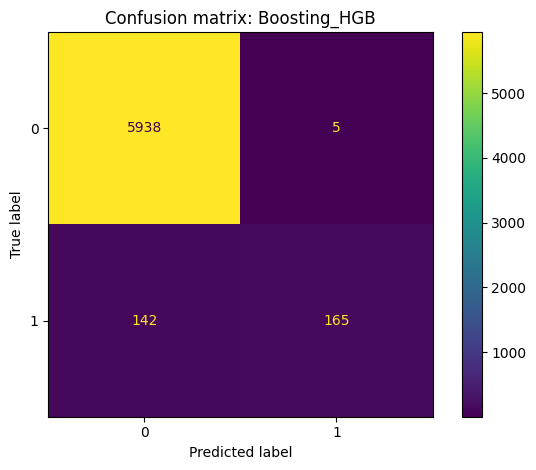

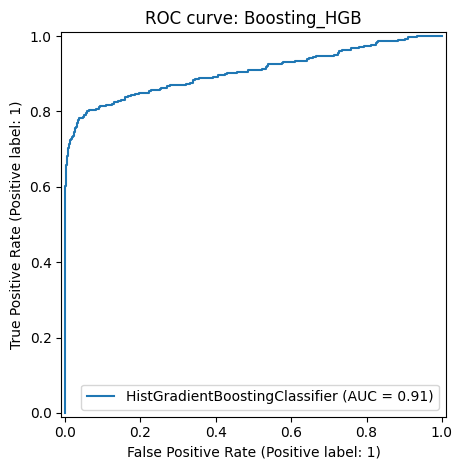

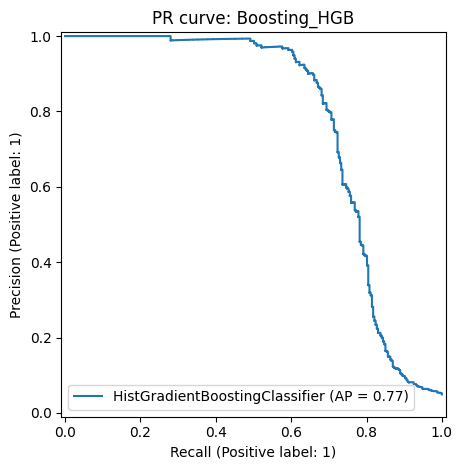

In [23]:
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
plt.title(f"Confusion matrix: {best_name}")
plt.tight_layout()
plt.savefig(FIG_DIR / f"cm_best_{best_name}.png", dpi=150)
plt.show()

RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.title(f"ROC curve: {best_name}")
plt.tight_layout()
plt.savefig(FIG_DIR / f"roc_best_{best_name}.png", dpi=150)
plt.show()

PrecisionRecallDisplay.from_estimator(best_model, X_test, y_test)
plt.title(f"PR curve: {best_name}")
plt.tight_layout()
plt.savefig(FIG_DIR / f"pr_best_{best_name}.png", dpi=150)
plt.show()


In [24]:
perm = permutation_importance(
    best_model, X_test, y_test,
    n_repeats=10,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

imp = pd.DataFrame({
    "feature": X.columns,
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std
}).sort_values("importance_mean", ascending=False)

top_k = 15
display(imp.head(top_k))


,feature,importance_mean,importance_std
24,f25,0.011504,0.001161
53,f54,0.005456,0.001096
57,f58,0.005104,0.000605
46,f47,0.004496,0.000388
32,f33,0.003648,0.000539
52,f53,0.003520,0.000535
12,f13,0.003184,0.000613
37,f38,0.002976,0.000454
10,f11,0.001760,0.000701
7,f08,0.001584,0.000354


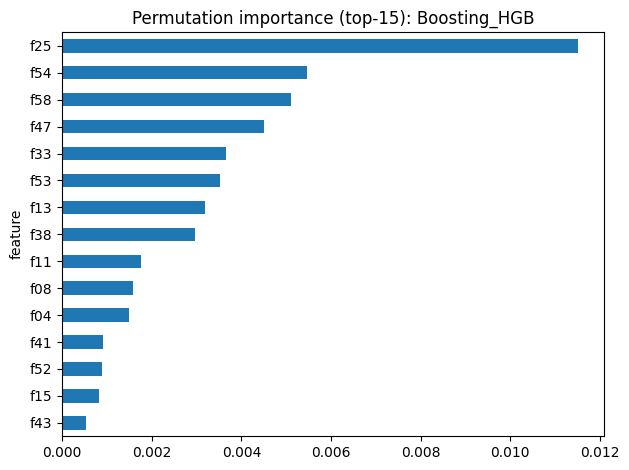

In [25]:
imp_plot = imp.head(top_k).iloc[::-1]
imp_plot.plot.barh(x="feature", y="importance_mean", legend=False)

plt.title(f"Permutation importance (top-{top_k}): {best_name}")
plt.tight_layout()
plt.savefig(FIG_DIR / f"perm_importance_{best_name}.png", dpi=150)
plt.show()


### Интерпретация permutation importance (Boosting_HGB)

Permutation importance показывает, насколько ухудшается качество модели, если случайно перемешать значения признака.  
В топ-15 самых важных вошли: **f25** (самый сильный вклад), затем **f54, f58, f47, f33, f53** и далее **f13, f38, f11, f08, f04, f41, f52, f15, f43**.

Это означает, что модель в основном опирается на небольшой набор наиболее информативных признаков: перемешивание **f25** сильнее всего снижает качество, поэтому он ключевой для разделения классов.  
Важности носят “прикладной” характер: они показывают, какие признаки важны для предсказаний модели, но не доказывают причинность.


In [27]:
# 1) сохраняем best_model.joblib
dump(best_model, ART_DIR / "best_model.joblib")

# 2) best_model_meta.json
best_model_meta = {
    "best_model_name": best_name,
    "selection_metric": "roc_auc",
    "selection_source": "cv_train",
    "best_cv_score": float(searches[best_name].best_score_),
    "best_model_params": best_model.get_params() if hasattr(best_model, "get_params") else {},
    "test_metrics": metrics_test[best_name],
    "random_state": RANDOM_STATE,
    "test_size": TEST_SIZE,
    "dataset_path": str(DATA_PATH)
}

with open(ART_DIR / "best_model_meta.json", "w", encoding="utf-8") as f:
    json.dump(best_model_meta, f, ensure_ascii=False, indent=2)

# 3) финально сохраняем метрики по всем моделям (baseline + week6)
with open(ART_DIR / "metrics_test.json", "w", encoding="utf-8") as f:
    json.dump(metrics_test, f, ensure_ascii=False, indent=2)

print("Saved artifacts:")
print("-", ART_DIR / "best_model.joblib")
print("-", ART_DIR / "best_model_meta.json")
print("-", ART_DIR / "metrics_test.json")


Saved artifacts:
- artifacts\best_model.joblib
- artifacts\best_model_meta.json
- artifacts\metrics_test.json
